# Fig 3. Quantile-based verif

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
import verif_utils as vu

In [2]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
import matplotlib.lines as mlines

from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 1.5
#mpl.rcParams['hatch.linewidth'] = 1.0

### Load config

In [4]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

### Figure settings

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

## Data

In [6]:
# ds_static = xr.open_zarr(conf['geo']['geo_file_zarr'])
# grid_lat = ds_static['lat2d'].values
# grid_lon = ds_static['lon2d'].values

In [7]:
ds_static = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/static/ERA5_mlevel_1deg_static_for_interp.zarr'
)
lsm = ds_static['land_sea_mask'].values
lsm = lsm.astype(bool) # <-- land-sea mask

**Pull full-domain data on day-1, 5, and 10**

In [8]:
base_dir = '/glade/campaign/cisl/aiml/ksha/CREDIT_cp/'
ds_TP = xr.open_dataset(base_dir+'VERIF/fuxi_w_physics2/Histogram_vals_001d_fuxi_physics.nc')
TP_plevel_phy_01 = 1e3*ds_TP['total_precipitation'].values
ds_TP = xr.open_dataset(base_dir+'VERIF/fuxi_w_physics2/Histogram_vals_005d_fuxi_physics.nc')
TP_plevel_phy_05 = 1e3*ds_TP['total_precipitation'].values
ds_TP = xr.open_dataset(base_dir+'VERIF/fuxi_w_physics2/Histogram_vals_010d_fuxi_physics.nc')
TP_plevel_phy_10 = 1e3*ds_TP['total_precipitation'].values

ds_TP = xr.open_dataset(base_dir+'VERIF/fuxi_mlevel_physics2/Histogram_vals_001d_fuxi_mlevel_physics.nc')
TP_mlevel_phy_01 = 1e3*ds_TP['total_precipitation'].values
ds_TP = xr.open_dataset(base_dir+'VERIF/fuxi_mlevel_physics2/Histogram_vals_005d_fuxi_mlevel_physics.nc')
TP_mlevel_phy_05 = 1e3*ds_TP['total_precipitation'].values
ds_TP = xr.open_dataset(base_dir+'VERIF/fuxi_mlevel_physics2/Histogram_vals_010d_fuxi_mlevel_physics.nc')
TP_mlevel_phy_10 = 1e3*ds_TP['total_precipitation'].values

ds_TP = xr.open_dataset(base_dir+'VERIF/fuxi_mlevel_dry2/Histogram_vals_001d_fuxi_mlevel_dry.nc')
TP_mlevel_dry_01 = 1e3*ds_TP['total_precipitation'].values
ds_TP = xr.open_dataset(base_dir+'VERIF/fuxi_mlevel_dry2/Histogram_vals_005d_fuxi_mlevel_dry.nc')
TP_mlevel_dry_05 = 1e3*ds_TP['total_precipitation'].values
ds_TP = xr.open_dataset(base_dir+'VERIF/fuxi_mlevel_dry2/Histogram_vals_010d_fuxi_mlevel_dry.nc')
TP_mlevel_dry_10 = 1e3*ds_TP['total_precipitation'].values

ds_TP = xr.open_dataset('/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/IFS/Histogram_vals_001d_IFS.nc')
TP_IFS_01 = 1e3*ds_TP['total_precipitation'].values
ds_TP = xr.open_dataset('/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/IFS/Histogram_vals_005d_IFS.nc')
TP_IFS_05 = 1e3*ds_TP['total_precipitation'].values
ds_TP = xr.open_dataset('/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/IFS/Histogram_vals_010d_IFS.nc')
TP_IFS_10 = 1e3*ds_TP['total_precipitation'].values

ds_TP = xr.open_dataset(base_dir+'/VERIF/IMERG/Histogram_vals_daily_IMERG.nc')
TP_IMERG = 1e3*ds_TP['total_precipitation'].values

**Compute quantiles on land for 0.01-0.99**

In [9]:
bins = np.arange(1, 100, 1)

QQ_plot = {}
QQ_plot['fuxi_physics_01'] = np.percentile(TP_plevel_phy_01.ravel(), bins)
QQ_plot['fuxi_physics_05'] = np.percentile(TP_plevel_phy_05.ravel(), bins)
QQ_plot['fuxi_physics_10'] = np.percentile(TP_plevel_phy_10.ravel(), bins)

QQ_plot['fuxi_mlevel_physics_01'] = np.percentile(TP_mlevel_phy_01.ravel(), bins)
QQ_plot['fuxi_mlevel_physics_05'] = np.percentile(TP_mlevel_phy_05.ravel(), bins)
QQ_plot['fuxi_mlevel_physics_10'] = np.percentile(TP_mlevel_phy_10.ravel(), bins)

QQ_plot['fuxi_mlevel_dry_01'] = np.percentile(TP_mlevel_dry_01.ravel(), bins)
QQ_plot['fuxi_mlevel_dry_05'] = np.percentile(TP_mlevel_dry_05.ravel(), bins)
QQ_plot['fuxi_mlevel_dry_10'] = np.percentile(TP_mlevel_dry_10.ravel(), bins)

QQ_plot['IFS_01'] = np.percentile(TP_IFS_01.ravel(), bins)
QQ_plot['IFS_05'] = np.percentile(TP_IFS_05.ravel(), bins)
QQ_plot['IFS_10'] = np.percentile(TP_IFS_10.ravel(), bins)

QQ_plot['IMERG'] = np.percentile(TP_IMERG.ravel(), bins)

QQ_plot_land = {}
QQ_plot_land['fuxi_physics_01'] = np.percentile(TP_plevel_phy_01[:, lsm].ravel(), bins)
QQ_plot_land['fuxi_physics_05'] = np.percentile(TP_plevel_phy_05[:, lsm].ravel(), bins)
QQ_plot_land['fuxi_physics_10'] = np.percentile(TP_plevel_phy_10[:, lsm].ravel(), bins)

QQ_plot_land['fuxi_mlevel_physics_01'] = np.percentile(TP_mlevel_phy_01[:, lsm].ravel(), bins)
QQ_plot_land['fuxi_mlevel_physics_05'] = np.percentile(TP_mlevel_phy_05[:, lsm].ravel(), bins)
QQ_plot_land['fuxi_mlevel_physics_10'] = np.percentile(TP_mlevel_phy_10[:, lsm].ravel(), bins)

QQ_plot_land['fuxi_mlevel_dry_01'] = np.percentile(TP_mlevel_dry_01[:, lsm].ravel(), bins)
QQ_plot_land['fuxi_mlevel_dry_05'] = np.percentile(TP_mlevel_dry_05[:, lsm].ravel(), bins)
QQ_plot_land['fuxi_mlevel_dry_10'] = np.percentile(TP_mlevel_dry_10[:, lsm].ravel(), bins)

QQ_plot_land['IFS_01'] = np.percentile(TP_IFS_01[:, lsm].ravel(), bins)
QQ_plot_land['IFS_05'] = np.percentile(TP_IFS_05[:, lsm].ravel(), bins)
QQ_plot_land['IFS_10'] = np.percentile(TP_IFS_10[:, lsm].ravel(), bins)

QQ_plot_land['IMERG'] = np.percentile(TP_IMERG[:, lsm].ravel(), bins)

**Test quantile diff**

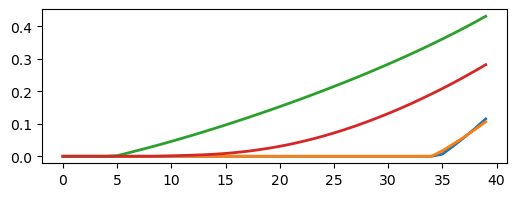

In [10]:
#ref_x = np.linspace(0, 0.0001)
plt.figure(figsize=(6, 2))
plt.plot((QQ_plot['fuxi_physics_10']-QQ_plot_land['IMERG'])[:40], lw=2)
plt.plot((QQ_plot['fuxi_mlevel_physics_10']-QQ_plot_land['IMERG'])[:40], lw=2)
plt.plot((QQ_plot['fuxi_mlevel_dry_10']-QQ_plot_land['IMERG'])[:40], lw=2)
plt.plot((QQ_plot['IFS_10']-QQ_plot_land['IMERG'])[:40], lw=2)
#plt.plot(ref_x, ref_x, 'k--')

## Plot

In [11]:
# grid_shape = grid_lat.shape
my_colors = gu.ksha_color_set_summon(color_set=0)

red = my_colors['red'] # fuxi-mlevel-physics
orange = my_colors['orange'] # fuxi-mlevel-base
blue = my_colors['blue'] # fuxi-plevel-physics
gray = '0.75' # IFS

In [12]:
# line specs
line_keys = {}
line_keys['IFS'] = {
    'linewidth': 5, 'linestyle': '-', 'color': gray, 'alpha': 1, 'zorder': 2, 'label': ''
}

line_keys['fuxi_physics'] = {
    'linewidth': 4, 'linestyle': '--', 'color': blue, 'alpha': 1, 'zorder': 4, 'label': ''
}

line_keys['fuxi_mlevel_physics'] = {
    'linewidth': 4, 'linestyle': '--', 'color': red, 'alpha': 1, 'zorder': 5, 'label': ''
}

line_keys['fuxi_mlevel_dry'] = {
    'linewidth': 4, 'linestyle': '-', 'color': orange, 'alpha': 1, 'zorder': 3, 'label': ''
}

# lead time settings
LEADs = np.arange(24, 240+24, 24)
N_leads = len(LEADs)
LEAD_ticks = np.arange(24, 240+24, 24)
model_name_keys = ['IFS', 'fuxi_physics', 'fuxi_mlevel_physics', 'fuxi_mlevel_dry']

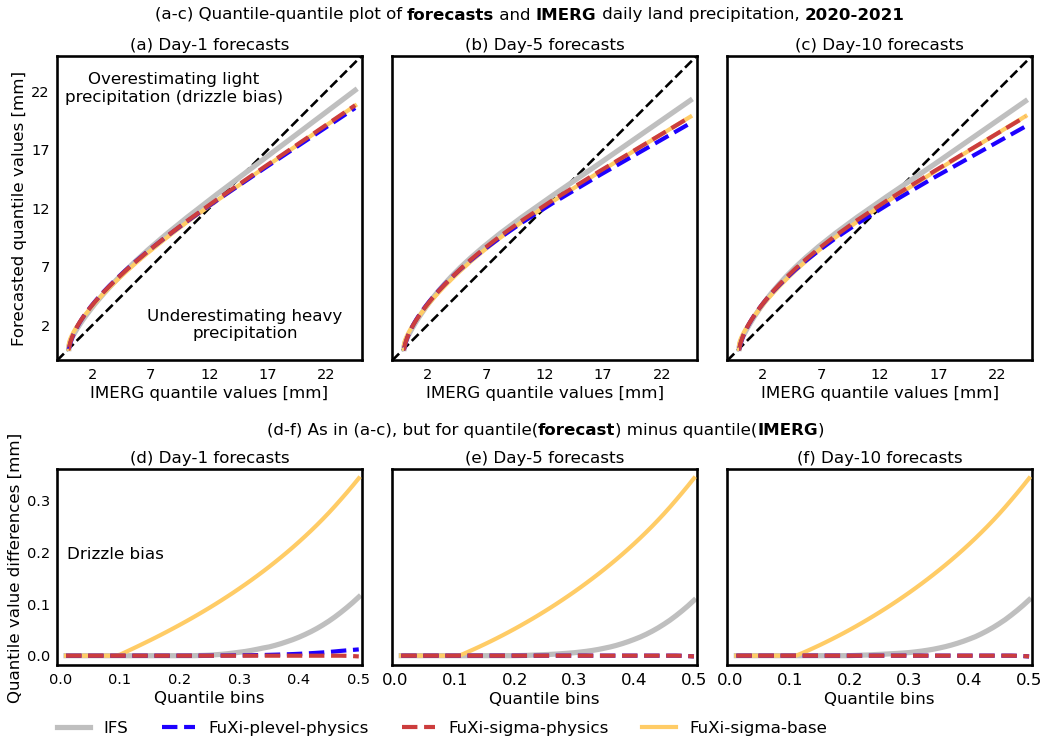

In [13]:
ref_x = np.linspace(-1, 40)

handles = []

fig = plt.figure(figsize=(13, 9), dpi=dpi_)
gs = gridspec.GridSpec(
    3, 3, 
    height_ratios=[1, 0.1, 0.45], 
    width_ratios=[1, 1, 1]
)

AX_QQ = []
AX_QQ.append(plt.subplot(gs[0, 0]))
AX_QQ.append(plt.subplot(gs[0, 1]))
AX_QQ.append(plt.subplot(gs[0, 2]))

AX_Qdiff = []
AX_Qdiff.append(plt.subplot(gs[2, 0]))
AX_Qdiff.append(plt.subplot(gs[2, 1]))
AX_Qdiff.append(plt.subplot(gs[2, 2]))


AX = AX_QQ + AX_Qdiff

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.1)

for i_ax, ax in enumerate(AX):
    ax = gu.ax_decorate_box(ax)

YLIMs = [
    [-1, 33.5],
    [-1, 25]
]

YTICKs = [
    [2, 9, 16, 23, 30],
    [2, 7, 12, 17, 22]
]

titles = ['(a) Day-1 forecasts', '(b) Day-5 forecasts', '(c) Day-10 forecasts']

for i_ax, ax in enumerate(AX_QQ):
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(labelbottom=True, labelsize=14)
    ax.set_xlim(YLIMs[1])
    ax.set_xticks(YTICKs[1])
    ax.set_ylim(YLIMs[1])
    ax.set_yticks(YTICKs[1])
    ax.plot(ref_x, ref_x, 'k--', lw=2.5)
    ax.set_xlabel('IMERG quantile values [mm]', fontsize=16)
    ax.set_title(titles[i_ax], fontsize=16)

titles = ['(d) Day-1 forecasts', '(e) Day-5 forecasts', '(f) Day-10 forecasts']

for i_ax, ax in enumerate(AX_Qdiff):
    ax.tick_params(labelbottom=True, labelsize=16)
    ax.set_xlim([-0.005, 0.505])
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_xlabel('Quantile bins', fontsize=16)
    ax.set_title(titles[i_ax], fontsize=16)
    
AX_QQ[0].tick_params(labelleft=True, labelsize=14)
AX_QQ[0].set_ylabel('Forecasted quantile values [mm]', fontsize=16)
AX_Qdiff[0].tick_params(labelleft=True, labelsize=14)
AX_Qdiff[0].set_ylabel('Quantile value differences [mm]', fontsize=16)

for name in model_name_keys:
    AX_QQ[0].plot(QQ_plot_land['IMERG'], QQ_plot_land[name+'_01'], **line_keys[name])
    AX_QQ[1].plot(QQ_plot_land['IMERG'], QQ_plot_land[name+'_05'], **line_keys[name])
    AX_QQ[2].plot(QQ_plot_land['IMERG'], QQ_plot_land[name+'_10'], **line_keys[name])
    
    AX_Qdiff[0].plot(0.01*bins[:50], (QQ_plot_land[name+'_01']-QQ_plot_land['IMERG'])[:50], **line_keys[name])
    AX_Qdiff[1].plot(0.01*bins[:50], (QQ_plot_land[name+'_05']-QQ_plot_land['IMERG'])[:50], **line_keys[name])
    AX_Qdiff[2].plot(0.01*bins[:50], (QQ_plot_land[name+'_10']-QQ_plot_land['IMERG'])[:50], **line_keys[name])

# Overall titles
fontsize_list = [16,]*10
fontweight_list = ['normal', 'bold']*5

ax_title0 = fig.add_axes([0.0, 0.95, 1.0, 0.025])
title_len = 0.8
handles += gu.string_partial_format(
    fig, ax_title0, 0.5*(1-title_len), 1.0, 'left', 'top', 
    [
        '(a-c) Quantile-quantile plot of ',
        'forecasts',
        ' and ', 
        'IMERG',
        ' daily land precipitation, ',
        '2020-2021',
    ], 
    ['k', 'k', 'k', 'k', 'k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

ax_title1 = fig.add_axes([0.0, 0.335, 1.0, 0.025])
title_len = 0.57
handles += gu.string_partial_format(
    fig, ax_title1, 0.5*(1-title_len), 1.0, 'left', 'top', 
    [
        '(d-f) As in (a-c), but for quantile(',
        'forecast',
        ') minus quantile(',
        'IMERG',
        ')',
    ], 
    ['k', 'k', 'k', 'k', 'k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], **line_keys['IFS']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi_physics']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi_mlevel_physics']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi_mlevel_dry']))

ax_lg1 = fig.add_axes([0.0, -0.1, 0.805, 0.04])
LG1 = ax_lg1.legend(
    handle_legneds1, ['IFS', 'FuXi-plevel-physics', 'FuXi-sigma-physics', 'FuXi-sigma-base'], 
    bbox_to_anchor=(1, 1), ncol=4, prop={'size':16})

ax_w1 = fig.add_axes([0.01, 0.825, 0.22, 0.06])
ax_w1.text(
    0.5, 0.5, 
    'Overestimating light\n'
    'precipitation (drizzle bias)',
    ha='center', va='center', fontsize=16, transform=ax_w1.transAxes);

ax_w2 = fig.add_axes([0.0825, 0.475, 0.22, 0.06])
ax_w2.text(
    0.5, 0.5, 
    'Underestimating heavy\n'
    'precipitation',
    ha='center', va='center', fontsize=16, transform=ax_w2.transAxes);

ax_w3 = fig.add_axes([0.01, 0.15, 0.1, 0.03])
ax_w3.text(
    0.5, 0.5, 
    'Drizzle bias',
    ha='center', va='center', fontsize=16, transform=ax_w3.transAxes);


ax_title0.set_axis_off()
ax_title1.set_axis_off()
ax_w1.set_axis_off()
ax_w2.set_axis_off()
ax_w3.set_axis_off()
LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()